# Disorder maps

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

## Get disorder maps

In [4]:
maps = get_disorder_maps()
maps = maps.loc[:, lambda x: ~np.isin(x.columns, ['AD', 'ANX', 'MCI', 'ADHD'])]
maps.head()

,ASD,MDD,SCZ
label,,,
lh_bankssts,-0.010,-0.008,-0.078
lh_caudalanteriorcingulate,-0.039,0.009,-0.049
lh_caudalmiddlefrontal,-0.033,-0.011,-0.088
lh_cuneus,0.010,-0.027,-0.066
lh_entorhinal,-0.024,-0.011,-0.055


## Get scores in DK

In [5]:
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')
scores_ds5 = dm_hcp_3d_ds5.score_in_dk()

dm_hcp_ds8 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds8')
scores_ds8 = dm_hcp_ds8.score_in_dk()

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8


In [46]:
correlate(scores_ds5.iloc[:,:3], scores_ds8)

,G1,G2,G3
G1,0.996021,-0.118611,0.148644
G2,-0.215473,0.958688,0.046838
G3,0.173330,-0.537493,0.905272


## Compute correlations using different nulls

In [25]:
nulls_ds5 = {
    'hcp_ds5 -> sim_5000 -> dk': np.load("../outputs/permutations/hcp_3d_ds5_sim_5000_in_dk.npy"),
    'hcp_ds5 -> spin_5000 -> dk': np.load("../outputs/permutations/hcp_3d_ds5_spin_5000_in_dk.npy"),
    'hcp_ds5 -> dk -> sim_5000': np.load("../outputs/permutations/sim_dk_5000_dm_hcp_3d_ds5_vertices.npy"),
    'hcp_ds5 -> dk -> spin_5000': np.load("../outputs/permutations/spin_dk_5000_dm_hcp_3d_ds5_vertices.npy")
}

nulls_ds8 = {
    'hcp_ds8 -> sim_5000 -> dk': np.load("../outputs/permutations/hcp_ds8_sim_5000_in_dk.npy"),
    'hcp_ds8 -> spin_5000 -> dk': np.load("../outputs/permutations/hcp_ds8_spin_5000_in_dk.npy"),
    'hcp_ds8 -> dk -> sim_5000': np.load("../outputs/permutations/sim_dk_5000_dm_hcp_ds8_vertices.npy"),
    'hcp_ds8 -> dk -> spin_5000': np.load("../outputs/permutations/spin_dk_5000_dm_hcp_ds8_vertices.npy")
}

In [13]:
null_corrs_dict_ds5 = {name: corr_nulls_from_grads(nulls, scores_ds5, maps) for name, nulls in nulls_ds5.items()}
null_corrs_dict_ds8 = {name: corr_nulls_from_grads(nulls, scores_ds8, maps) for name, nulls in nulls_ds8.items()}

In [26]:
null_corrs_dict = {**null_corrs_dict_ds5, **null_corrs_dict_ds8}
corr_versions = {version:stats for version, stats in null_corrs_dict.items()}
corr_versions = pd.concat(corr_versions).reset_index().set_axis(['version','G','map','r','p','q'], axis=1)

In [33]:
corr_versions = corr_versions.set_index('version').loc[list(nulls_ds5.keys())+list(nulls_ds8.keys())].reset_index()

In [34]:
save_pickle(corr_versions, 'corr_versions_disorders')

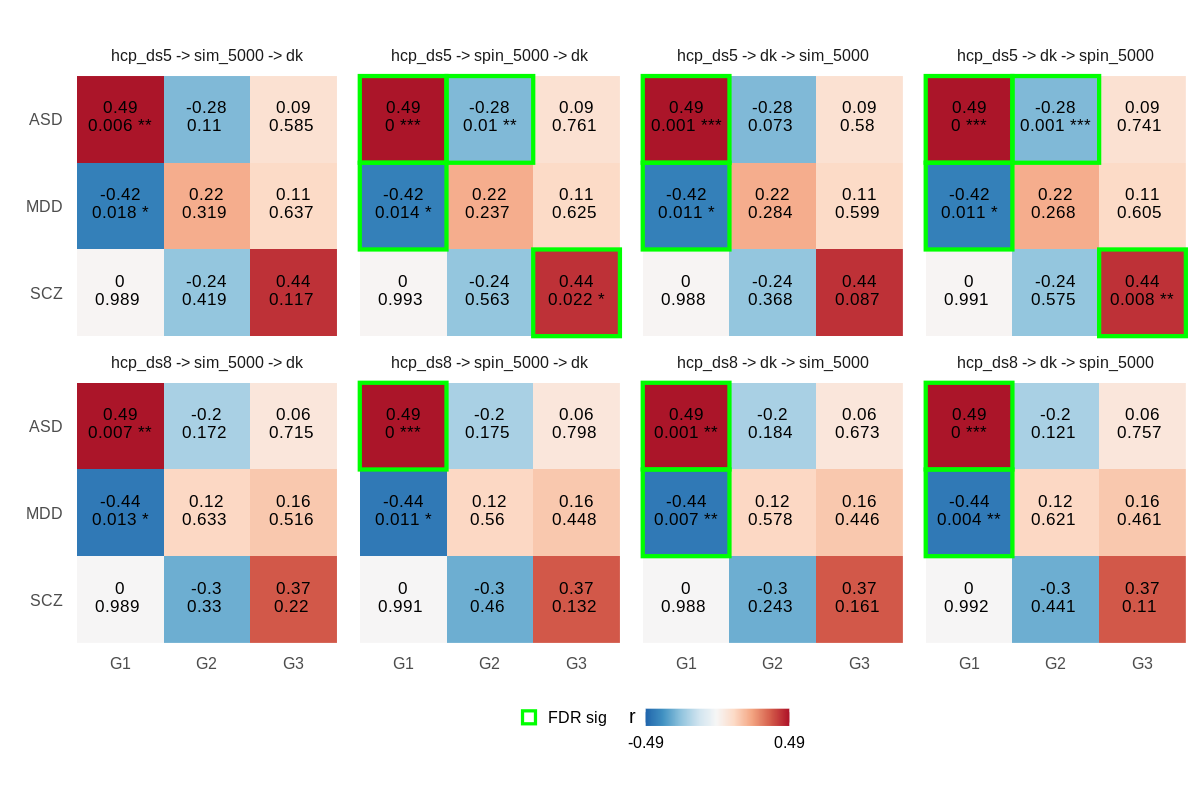

In [37]:
%%R -i corr_versions -w 1200 -h 800
source("../code/plot_maps.R")
plot_corr_versions(corr_versions, facet='w', nrow=2)

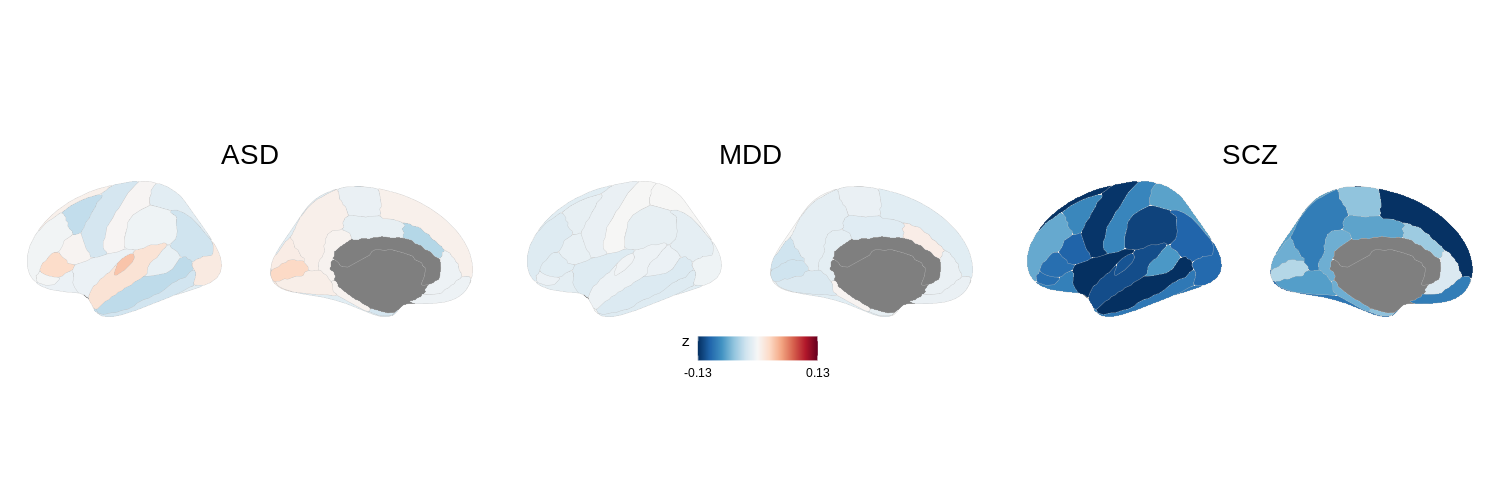

In [44]:
%%R -i scores_ds8 -i scores_ds5 -i maps -w 15 -h 5 --units in -r 100
# plot_dk(scores_ds5, facet='w')
plot_maps_dk(maps)

## Project all HCP nulls to DK

More reliable than making nulls in DK?

In [3]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [5]:
hcp_nulls = np.load('../outputs/permutations/hcp_3d_ds5_sim_10000.npy')

Project into dk

In [ ]:
n = hcp_nulls.shape[2]
dk_nulls = np.zeros((34,3,n))
for i in range(n):
    index = dm_hcp_3d_ds5.scores.index # Get non-missing labels
    hcp_null_scores = pd.DataFrame(hcp_nulls[:,:,i], index=index)
    dk_nulls[:,:,i] = project_to_dk(hcp_null_scores)

np.save('../outputs/permutations/hcp_3d_ds5_sim_10000_in_dk.npy', dk_nulls)


## Make distance matrix for DK atlas

Only need to do this once

In [4]:
# from brainsmash.workbench.geo import parcellate
# infile = "/home/rajd2/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/LeftDenseGeodesicDistmat.txt"
# outfile = "../data/LeftParcelGeodesicDistmat_DK.txt"
# dlabel = "../data/fsaverage.aparc.32k_fs_L.dlabel.nii"
# parcellate(infile, dlabel, outfile)

---

In [12]:
pca_dk_ds5 = gradientVersion(approach='pca').fit('dk_ds5')

New gradients version: method=pca, params={}, kernel=normalized_angle, sparsity=0, data=dk_ds5


In [32]:
from sklearn.cross_decomposition import PLSCanonical
X = pca_dk_ds5.expression
Y = maps['SCZ']
scz_weights = PLSCanonical(n_components=1).fit(X,Y).x_weights_

In [34]:
scz_weights = pd.Series(scz_weights.squeeze(), index=X.columns)

In [20]:
from disorders import *
gandal_genes = get_gandal_genes()
disorders = ['ASD','MDD','SCZ']

In [22]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
weights = dm_hcp_3d_ds5.weights

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [23]:
gandal_fdr = (gandal_genes
              .loc[:,[f'{d}.FDR' for d in disorders]]
              .melt(ignore_index=False, var_name='disorder', value_name='FDR')
              # .loc[lambda x: x['FDR']]
              .assign(disorder = lambda x: x['disorder'].str.replace('.FDR','', regex=False))
              .set_index('disorder', append=True)
             )

gandal_log2FC = (gandal_genes
              .loc[:,[f'{d}.log2FC' for d in disorders]]
              .melt(ignore_index=False, var_name='disorder', value_name='log2FC')
              .assign(disorder = lambda x: x['disorder'].str.replace('.log2FC','', regex=False))
              .set_index('disorder', append=True)
              .join(gandal_fdr)
              .reset_index('disorder')
              .loc[lambda x: x['FDR'] < 0.05]
             )

weights_labels = (weights
                  .join(gandal_log2FC)     
                  .rename({'disorder':'label'}, axis=1)                   
                  .fillna({'label':'none'})
                  .assign(cluster = lambda x: np.select([x['log2FC']>0,x['log2FC']<0], ['upregulated','downregulated'], default=None)) 
                  # .drop(['sig'], axis=1)
                 )
weights_labels

,0,1,2,3,4,label,log2FC,FDR,cluster
A1BG,-0.015451,-0.004935,0.000699,0.016858,0.006289,none,NaN,NaN,None
A1BG-AS1,-0.011982,-0.001215,-0.016185,0.007906,0.010129,none,NaN,NaN,None
AAAS,0.011610,0.004924,0.002747,0.021268,0.015138,none,NaN,NaN,None
AAED1,-0.013839,-0.000380,0.008323,0.002260,0.008065,none,NaN,NaN,None
AAGAB,-0.005098,0.019883,-0.014753,0.008614,-0.010403,none,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
ZSWIM9,-0.009991,0.000472,0.002506,-0.019020,0.018501,none,NaN,NaN,None
ZWINT,-0.012440,-0.008334,0.000574,0.004192,0.005409,none,NaN,NaN,None
ZYX,0.017013,0.005947,-0.003734,0.009057,-0.000945,SCZ,-0.054705,0.019563,downregulated
ZZEF1,0.013004,-0.012944,0.009703,-0.000583,0.013878,none,NaN,NaN,None


In [45]:
(weights_labels.loc[lambda x: x['label']=='SCZ']
 .join(scz_weights.rename('SCZ_PLS_weights')).corr()
 .loc['SCZ_PLS_weights'].drop(['FDR',3,4,'SCZ_PLS_weights'])
)

0         0.116266
1         0.460877
2        -0.746020
log2FC   -0.529059
Name: SCZ_PLS_weights, dtype: float64

---

## Get gradients

In [6]:
# pca_dk_ds9 = gradientVersion(approach='pca').fit('dk_ds9')
# dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')
# dm_dk_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds5')

# dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
# dm_hcp_ds8 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds8')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


Translate HCP gradient scores into DK using Neuromaps

In [8]:
dk_scores = dm_hcp_3d_ds5.score_in_dk()

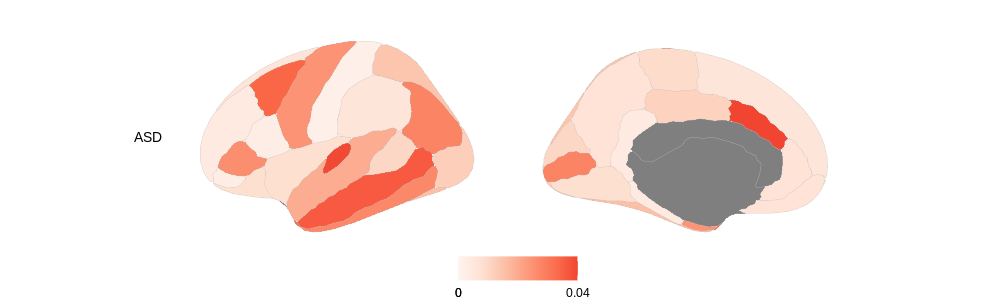

In [82]:
%%R -i dk_scores -i maps -w 10 -h 3 --units in -r 100
# %%R -i dk_scores -i maps -w 5 -h 10 --units in -r 100

source("../code/brainPlots.R")
source("../code/plot_maps.R")
library(dplyr)
# plot_dk(dk_scores, switch='y') / plot_maps_dk(maps, ncol=1, colors=rev(brewer.puor(100)), facet='v')
plot_maps_dk(maps %>% select(ASD), ncol=1, colors=brewer.reds(100)[1:60], facet='v', colorscale='zero')

In [66]:
dk_scores_dict = {
    # 'dm_hcp_ds8_vertices': dm_hcp_ds8.score_in_dk(),
    # 'dm_hcp_ds9_vertices': dm_hcp_ds9.score_in_dk(),
    'dm_hcp_3d_ds5_vertices': dm_hcp_3d_ds5.score_in_dk()
}

dk_scores = (pd.concat(dk_scores_dict)
             .reset_index(0)
             .rename({'level_0':'version'}, axis=1)
            )

In [27]:
for name, scores in {name:scores for name,scores in dk_scores_dict.items() if 'vertices' in name}.items():
    generate_spins_from_gradients(scores, n=100, outfile=f'../outputs/permutations/spin_dk_100_{name}.npy', atlas='dk')
    print(f'Made spins for {name}')

KeyboardInterrupt: 

In [27]:
for name, scores in {name:scores for name,scores in dk_scores_dict.items() if 'vertices' in name}.items():
    generate_spins_from_gradients(scores, n=10000, outfile=f'../outputs/permutations/spin_dk_100_{name}.npy', atlas='dk')
    print(f'Made spins for {name}')

KeyboardInterrupt: 

In [22]:
for name, scores in {name:scores for name,scores in dk_scores_dict.items() if 'vertices' in name}.items():
    generate_simulations(scores, n=10000, outfile=f'../outputs/permutations/sim_dk_10000_{name}.npy', atlas='dk')
    print(f'Made sims for {name}')

Made sims for dm_hcp_3d_ds5_vertices


In [32]:
for name, scores in {name:scores for name,scores in dk_scores_dict.items() if 'vertices' in name}.items():
    generate_shuffles(scores, n=5000, outfile=f'../outputs/permutations/shuffle_dk_5000_{name}.npy')
    print(f'Made shuffles for {name}')

Made shuffles for dm_hcp_3d_ds5_vertices


In [31]:
# null_corrs_dict = {}
# for name, scores in dk_scores_dict.items():
#     sim_grads = np.load(f"../outputs/permutations/sim_gradients_dk_1000_{name}.npy")
#     spin_grads = np.load(f"../outputs/permutations/spin_gradients_dk_1000_{name}.npy")    
#     null_corrs_dict[name] = corr_nulls_from_grads(spin_grads, scores, maps, method='pearson')

In [62]:
shuffle_grads = np.load(f"../outputs/permutations/shuffle_dk_5000_dm_hcp_3d_ds5_vertices.npy")    
spin_grads = np.load(f"../outputs/permutations/spin_dk_5000_dm_hcp_3d_ds5_vertices.npy")
hcp_sim_grads = np.load(f"../outputs/permutations/hcp_3d_ds5_sim_1000_in_dk.npy")


In [63]:
null_corrs_dict = {
    'Random null': corr_nulls_from_grads(shuffle_grads, dk_scores, maps, method='pearson'),
    'Spin null': corr_nulls_from_grads(spin_grads, dk_scores, maps, method='pearson'),
    'HCP sim null': corr_nulls_from_grads(hcp_sim_grads, dk_scores, maps, method='pearson')
}

In [64]:
corr_versions = {}
for name, null_corrs in null_corrs_dict.items():
    corrs = get_corrs(dk_scores, maps, atlas='dk')#.loc[lambda x: ~np.isin(x.index, ['ANX', 'MCI', 'ADHD'])]
    null_corrs = null_corrs_dict[name]#.loc[lambda x: ~np.isin(x['map'], ['ANX', 'MCI', 'ADHD'])]
    corr_versions[name] = get_null_p(corrs, null_corrs, adjust='fdr_bh')

names_dict = {
    # 'dm_hcp_ds9_vertices': 'DM HCP DS9 -> DK (vertices)',
    'dm_hcp_3d_ds5_vertices': 'DM HCP 3+ DS5 -> DK (vertices)'
}
    
corr_versions = pd.concat(corr_versions).reset_index(0).rename({'level_0':'version'},axis=1)
        # .assign(version = lambda x: pd.Categorical(x['version'].replace(names_dict), ordered=True, categories=names_dict.values()))

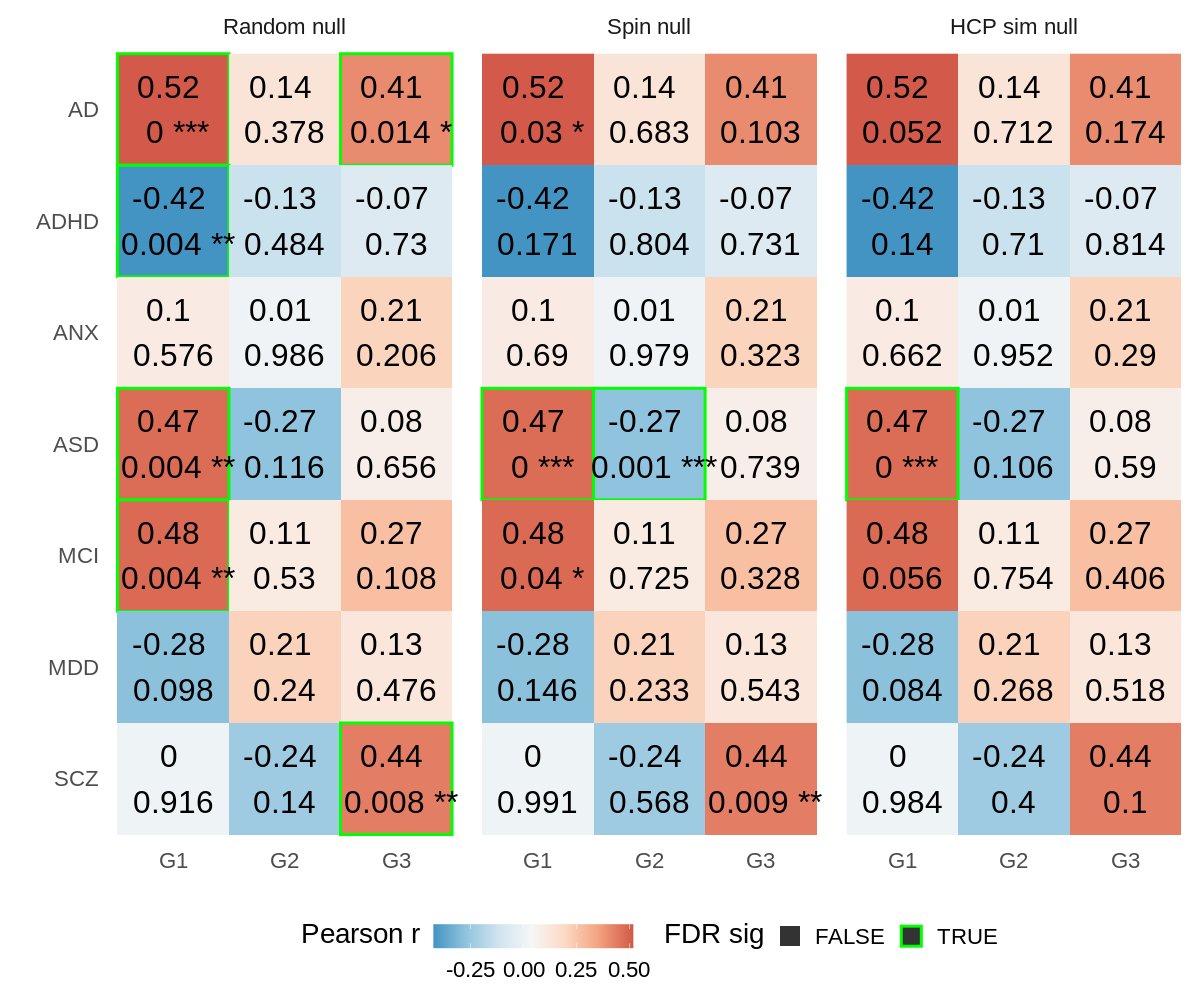

In [65]:
%%R -i corr_versions -i maps -i dk_scores -w 12 -h 10 --units in -r 100
source("../code/plot_maps.R")
plot_corr_versions_2(corr_versions, size=8)

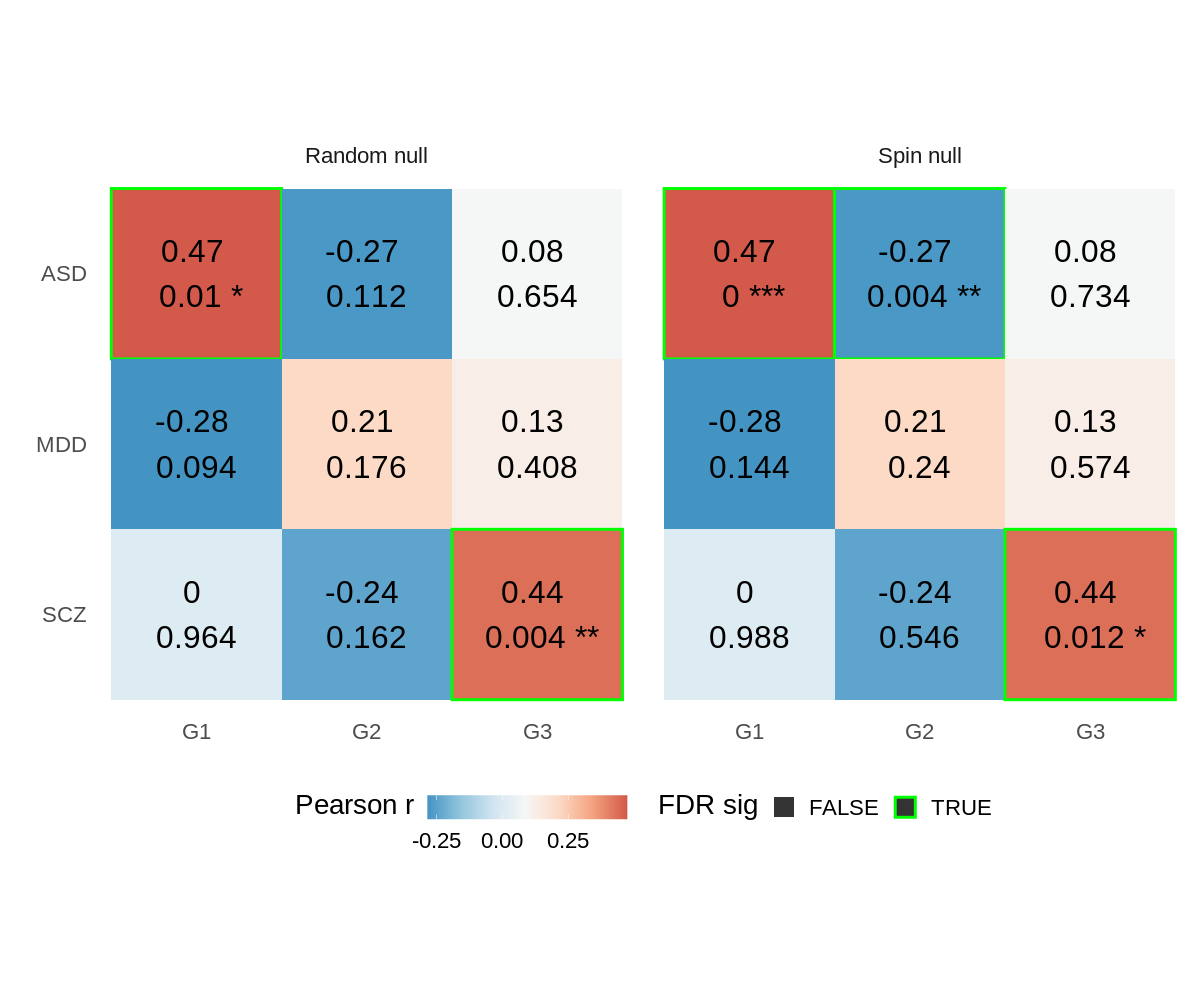

In [40]:
%%R -i corr_versions -i maps -i dk_scores -w 12 -h 10 --units in -r 100
source("../code/plot_maps.R")
plot_corr_versions_2(corr_versions, size=8)

In [50]:
maps_scatter = (maps
                .melt(ignore_index=False, var_name='map', value_name='map_score')
                .join(scores.set_index('label')).reset_index()
               )
maps_scatter_corrs = (corr_versions.loc[lambda x: x['version']=='Spin null']
                      .loc[:,['map','G','true_mean','q']]
                     )

In [54]:
maps_scatter_corrs

,map,G,true_mean,q
0,ASD,G1,0.473484,0.00000
1,ASD,G2,-0.274458,0.01800
2,ASD,G3,0.081860,0.82575
3,MDD,G1,-0.283795,0.32400
4,MDD,G2,0.214388,0.43200
5,MDD,G3,0.129684,0.73800
6,SCZ,G1,0.003600,0.98800
7,SCZ,G2,-0.242288,0.73800
8,SCZ,G3,0.435329,0.03600


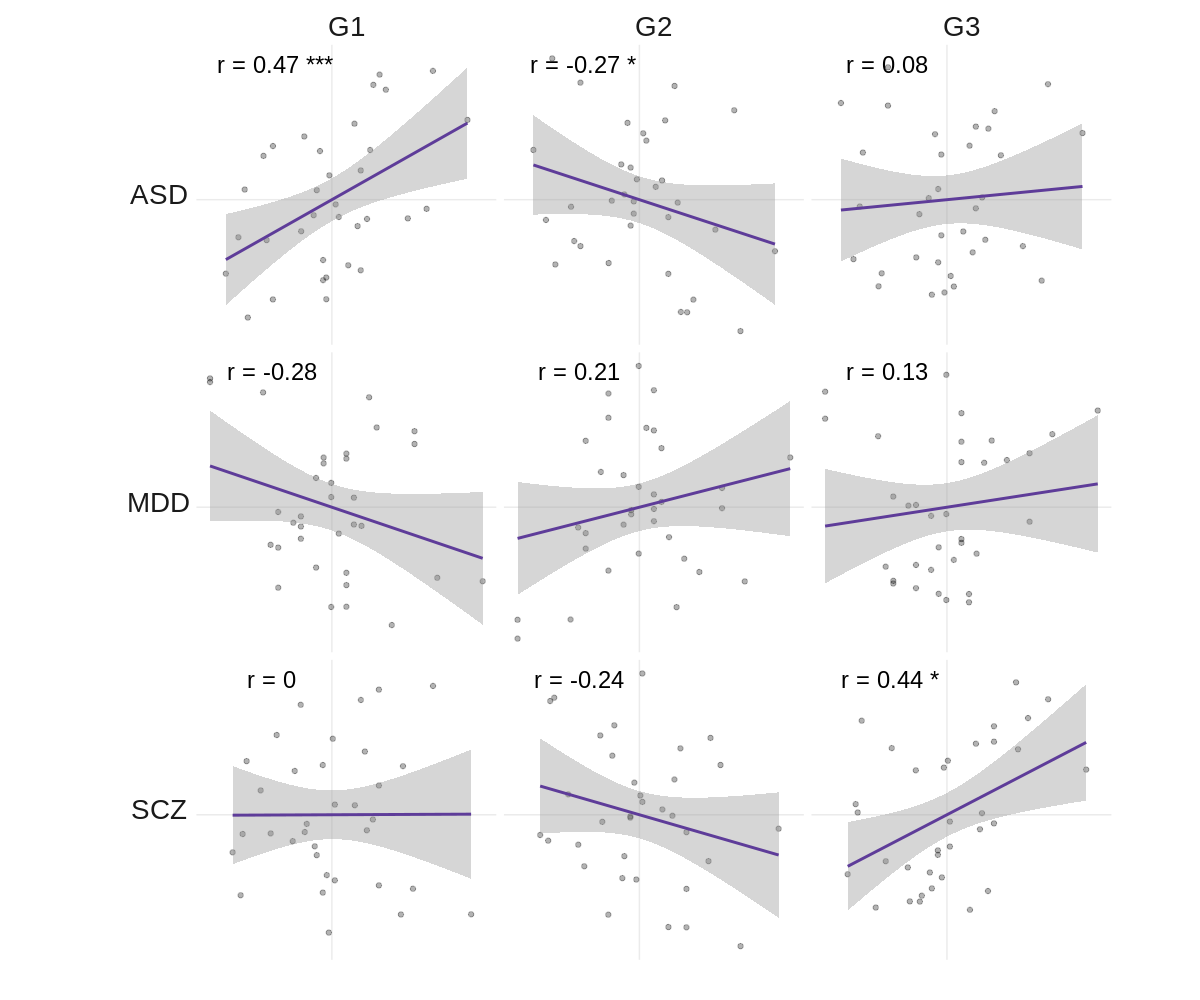

In [55]:
%%R -i maps_scatter -i maps_scatter_corrs -w 12 -h 10 --units in -r 100
source("../code/plot_maps.R")
plot_maps_scatter(maps_scatter, maps_scatter_corrs)

---

## Compare DK maps

In [134]:
dk_scores_dict = {
    'dm_dk_ds9': dm_dk_ds9.clean_scores(),
    'pca_dk_ds9': pca_dk_ds9.clean_scores(),
    'dm_hcp_ds9': dm_dk_ds9.score_from(dm_hcp_ds9),
    'dm_hcp_ds9_vertices': dm_hcp_ds9.score_in_dk(),
    'dm_hcp_3d_ds5': dm_dk_ds9.score_from(dm_hcp_3d_ds5),
    'dm_hcp_3d_ds5_vertices': dm_hcp_3d_ds5.score_in_dk()
}

dk_scores = (pd.concat(dk_scores_dict)
             .reset_index(0)
             .rename({'level_0':'version'}, axis=1)
            )

In [136]:
for name, scores in {name:scores for name,scores in dk_scores_dict.items() if 'vertices' in name}.items():
    generate_simulations(scores.set_index('label'), n=1000, outfile=f'../outputs/permutations/sim_gradients_dk_1000_{name}.npy', atlas='dk')
    print(f'Made simulations for {name}')

Made simulations for dm_hcp_ds9_vertices
Made simulations for dm_hcp_3d_ds5_vertices


In [181]:
null_corrs_dict = {}
for name, scores in dk_scores_dict.items():
    sim_grads = np.load(f"../outputs/permutations/sim_gradients_dk_1000_{name}.npy")
    null_corrs_dict[name] = corr_nulls_from_grads(sim_grads, scores, maps, method='pearson')

In [191]:
null_corrs_dict = {}
for name, scores in dk_scores_dict.items():
    sim_disorders = np.load(f"../outputs/permutations/sim_disorders_dk_5000.npy")
    null_corrs_dict[name] = corr_nulls_from_maps(sim_disorders, scores, maps, method='pearson')

In [182]:
corr_versions = {}
for name, scores in dk_scores_dict.items():
    corrs = get_corrs(scores, maps, atlas='dk')#.loc[lambda x: ~np.isin(x.index, ['ANX', 'MCI', 'ADHD'])]
    null_corrs = null_corrs_dict[name]#.loc[lambda x: ~np.isin(x['map'], ['ANX', 'MCI', 'ADHD'])]
    corr_versions[name] = get_null_p(corrs, null_corrs, adjust='fdr_bh')

names_dict = {
    'dm_dk_ds9': 'DM DK DS9',
    'pca_dk_ds9': 'PCA DK DS9',
    'dm_hcp_ds9': 'DM HCP DS9 \n-> DK (weights)',
    'dm_hcp_ds9_vertices': 'DM HCP DS9 \n-> DK (vertices)',
    'dm_hcp_3d_ds5': 'DM HCP 3+ DS5 \n-> DK (weights)',
    'dm_hcp_3d_ds5_vertices': 'DM HCP 3+ DS5 \n-> DK (vertices)'
}
    
corr_versions = pd.concat(corr_versions).reset_index(0).rename({'level_0':'version'},axis=1) \
        .assign(version = lambda x: pd.Categorical(x['version'].replace(names_dict), ordered=True, categories=names_dict.values()))

maps_plot = maps

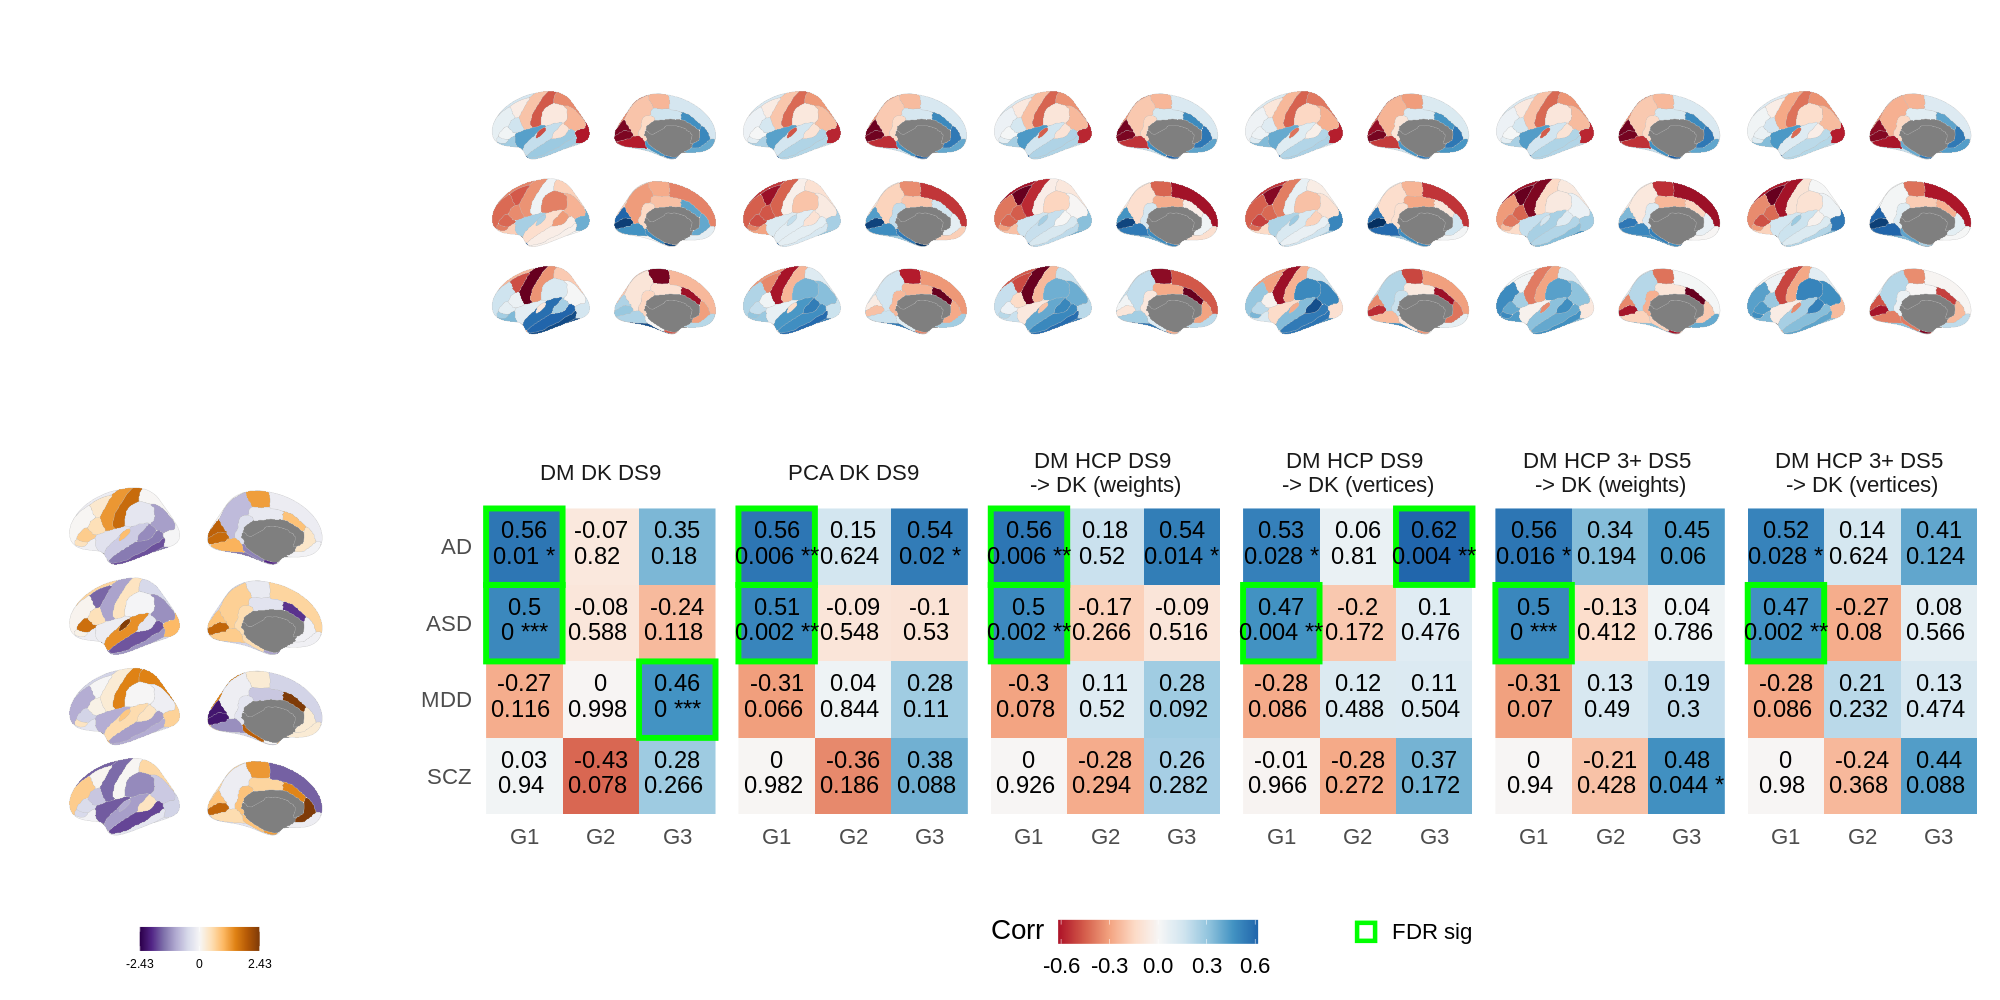

In [185]:
%%R -i corr_versions -i maps_plot -i dk_scores -w 20 -h 10 --units in -r 100
source("../code/plot_maps.R")
g1 <- plot_dk(dk_scores) + theme(strip.text.y=element_blank(), strip.text.x=element_blank()) + guides(fill='none')
g2 <- plot_corr_versions(corr_versions) #+ ggtitle('DK map versions')
g3 <- plot_maps_dk(maps_plot, ncol=1, colors=rev(brewer.puor(100))) + theme(strip.text.x=element_blank())

layout <- c(
  area(t = 1, b = 1, l = 3, r = 10),
  area(t = 2, b = 2, l = 3, r = 10),
  area(t = 2, b = 2, l = 1, r = 2)
)

plot <- g1 + g2 + g3 + plot_layout(design=layout)

plot #& theme(plot.margin=margin(0,0,0,0))

In [186]:
g = (dk_scores
 .set_index(['version', 'label'])
 # .loc['dm_hcp_3d_ds5_vertices']
 .loc['dm_hcp_3d_ds5_vertices']
 .join(maps)
)

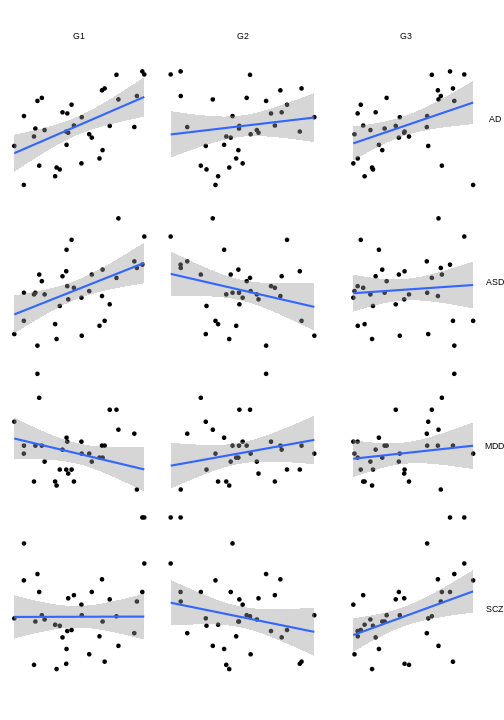

In [189]:
%%R -i g -w 7 -h 10 --units in
g %>%
gather(map, map_score, -(G1:G3)) %>%
gather(G, G_score, -map, -map_score) %>%
ggplot(aes(x=G_score, y=map_score)) + 
facet_grid(map ~ G) +
geom_point() + theme_void() + geom_smooth(method='lm') + 
theme(aspect.ratio=1)

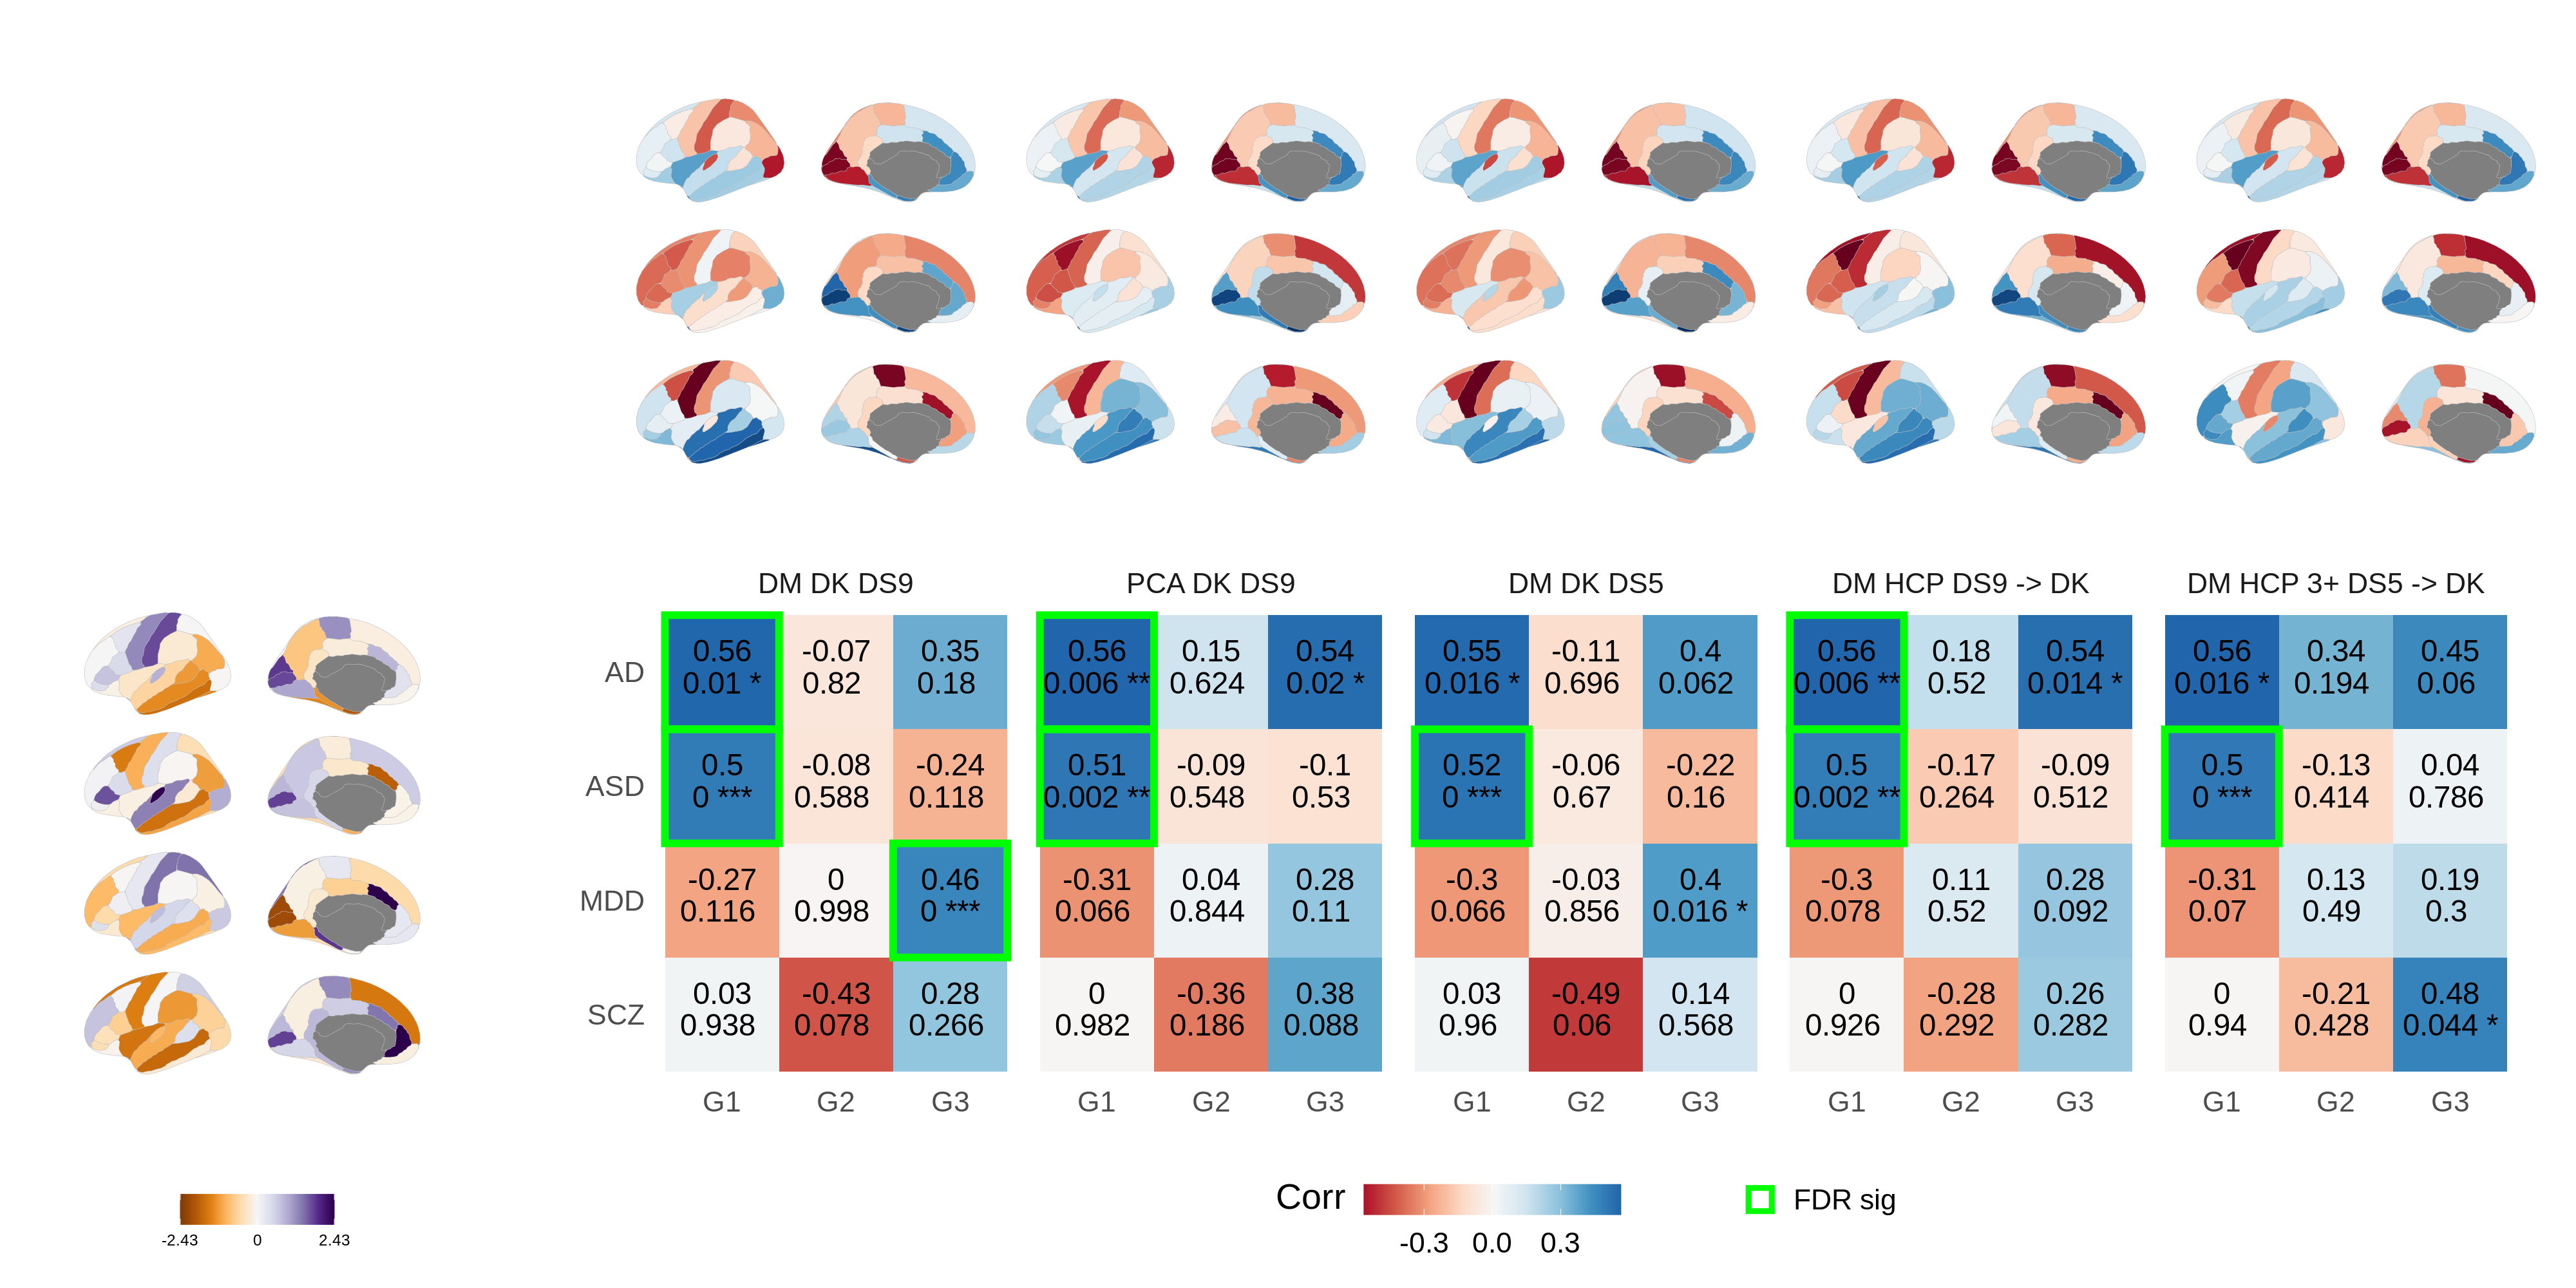

In [21]:
%%R -i corr_versions -i maps_plot -i dk_scores -w 20 -h 10 --units in -r 200
source("../code/plot_maps.R")
g1 <- plot_dk(dk_scores) + theme(strip.text.y=element_blank(), strip.text.x=element_blank()) + guides(fill='none')
g2 <- plot_corr_versions(corr_versions) #+ ggtitle('DK map versions')
g3 <- plot_maps_dk(maps_plot, ncol=1, colors=brewer.puor(100)) + theme(strip.text.x=element_blank())

layout <- c(
  area(t = 1, b = 1, l = 3, r = 10),
  area(t = 2, b = 2, l = 3, r = 10),
  area(t = 2, b = 2, l = 1, r = 2)
)

plot <- g1 + g2 + g3 + plot_layout(design=layout)

plot #& theme(plot.margin=margin(0,0,0,0))

---

## Biplot

In [421]:
corr = (corr_versions
        .loc[lambda x: x['version'] == 'DM HCP 3+ DS5 -> DK']
        .loc[:, ['G','map','z']]
        .pivot(index='map',columns='G', values='z')
       )
corr

G,G1,G2,G3
map,,,
AD,2.203900,1.340679,1.818634
ASD,3.441122,-0.790134,0.295433
MDD,-1.772213,0.727133,1.054310
SCZ,-0.080397,-0.856339,1.918507


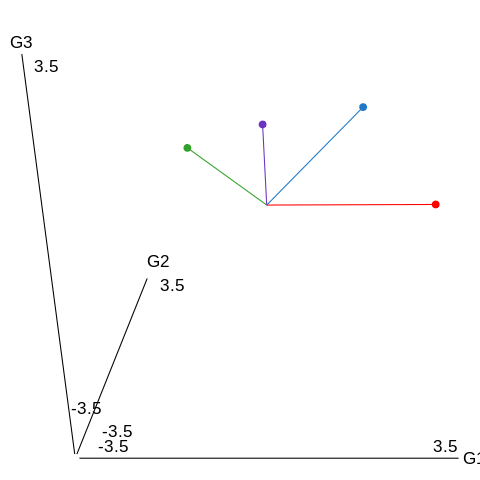

In [422]:
%%R -i corr
library(gg3D)

corr <- corr %>% round(2) %>% rownames_to_column('d')
corr_zero <- corr %>% mutate(across(G1:G3, ~ 0))
axes_pos <- corr %>% mutate(d = '_axes') %>% mutate(across(G1:G3, ~ 3.5))
axes_neg <- corr %>% mutate(d = '_axes') %>% mutate(across(G1:G3, ~ -3.5))
axes <- rbind(axes_pos, axes_neg)
corr_plot <- rbind(corr, corr_zero, axes)
# corr_bg <- rbind(corr, corr %>% mutate(across(G2, ~ -10*.x)))

# theta <- 170
theta <- 0
phi <- 20

g1 <- ggplot(corr_plot, aes(x=G1, y=G2, z=G3, color=d)) +
axes_3D(theta=theta, phi=phi) + 
stat_3D(geom='line', theta=theta, phi=phi) +
# stat_3D(data=corr,
#     geom='point', size=3, theta=theta, phi=phi) +
stat_3D(data=rbind(corr, axes), geom='point', size=3, theta=theta, phi=phi) +
scale_color_manual(values=c('white', cols25(4))) +
axis_labs_3D(theta=theta, phi=phi, size=6,
       hjust=c(1,0.5, -0.5,-0.5, -0.5,0), 
       vjust=c(-0.5,-0.5, 1,0.5, 1.5,-1)) +
labs_3D(theta=theta, phi=phi, size=6,
       labs=c('G1','G2','G3'),
       hjust=c(-0.2,0,0.5), vjust=c(0.5,-1,-0.5)) +
theme_void() + 
theme(legend.position = "none")
g1

In [423]:
%%R -i corr
corr <- corr %>% rownames_to_column('d')
df <- rbind(
    corr %>% select(d, x=G1, y=G3) %>% mutate(which='G1 v G3'),
    corr %>% select(d, x=G1, y=G2) %>% mutate(which='G1 v G2'),
    corr %>% select(d, x=G2, y=G3) %>% mutate(which='G2 v G3')
) %>%
mutate(which = factor(which, ordered=T, levels=unique(.$which)))

df_labs <- rbind(
    data.frame(x=c(-3.5, -0.5), y=c(0.5, 3.5), label=c('G1', 'G3'), which='G1 v G3'),
    data.frame(x=c(-3.5, -0.5), y=c(0.5, 3.5), label=c('G1', 'G2'), which='G1 v G2'),
    data.frame(x=c(-3.5, -0.5), y=c(0.5, 3.5), label=c('G2', 'G3'), which='G2 v G3')
) %>%
mutate(which = factor(which, ordered=T, levels=unique(.$which)))

lim <- 3.5

g2 <- ggplot(df) + 
facet_wrap(~which, ncol=1) + 
geom_hline(yintercept=0) + geom_vline(xintercept=0) +
geom_segment(aes(x=0,y=0,xend=x,yend=y, color=d)) +
geom_point(aes(x,y, color=d)) +
geom_text(data=df_labs, aes(x=x,y=y,label=label), size=6) +
annotate(geom='text', x=3.5, y=0.5, label='3.5', size=6) +
annotate(geom='text', x=0.5, y=-3.5, label='-3.5', size=6) +
scale_x_continuous(limits=c(-lim,lim)) + 
scale_y_continuous(limits=c(-lim,lim)) +
scale_color_manual(values=cols25(4), name='Disorder') +
coord_cartesian(clip='off') +
theme_void() + 
theme(aspect.ratio=1,
      panel.spacing=unit(2,'lines'),
      strip.text=element_blank(),
      legend.position='left'
     )

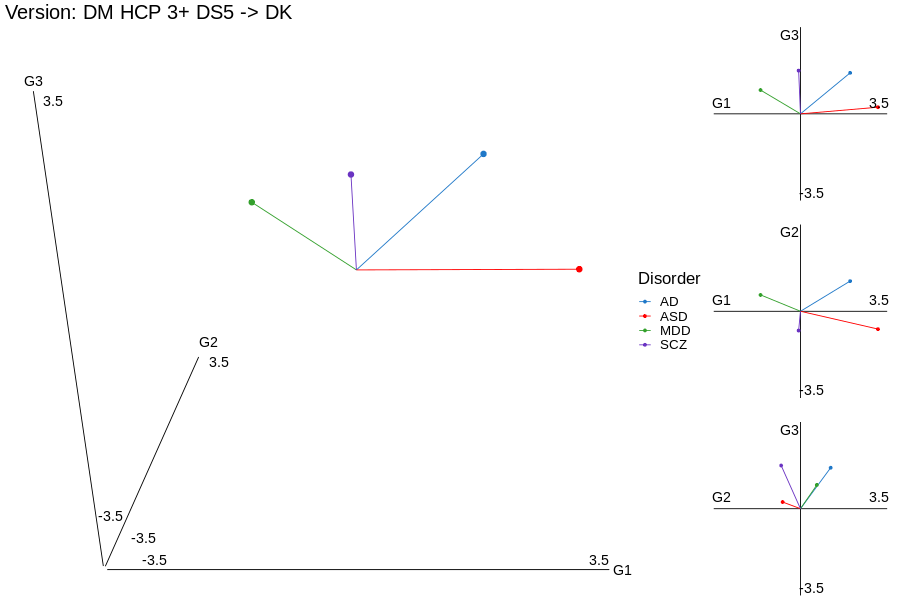

In [424]:
%%R -w 15 -h 10 --units in -r 60
layout <- c(
    area(t=1,b=10,l=1,r=10),
    area(t=1,b=10,l=11,r=13)
)

plot <- g1 + g2 + plot_layout(design=layout)
themed <- plot & theme(text=element_text(size=20))
annotated <- themed + plot_annotation(title='Version: DM HCP 3+ DS5 -> DK')
annotated

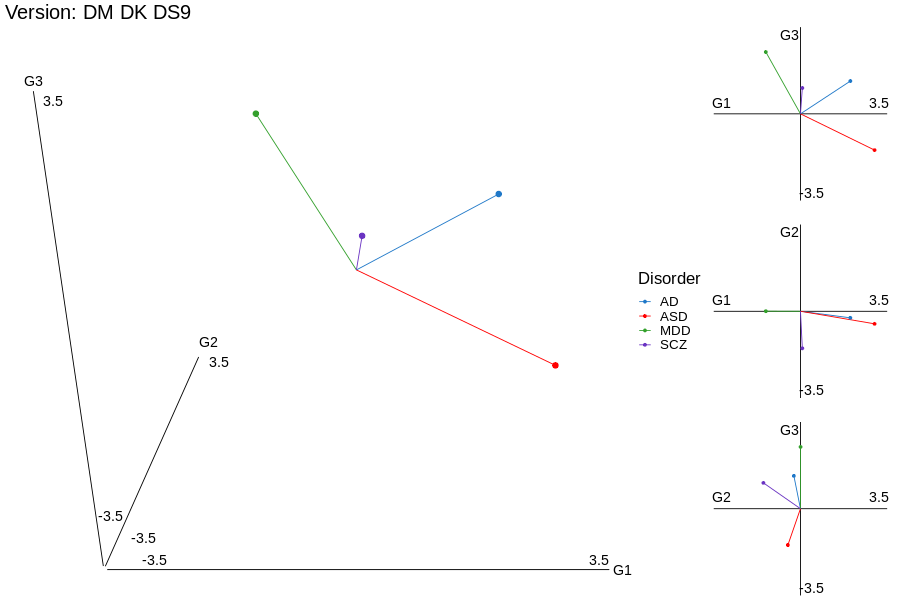

In [418]:
%%R -w 15 -h 10 --units in -r 60
layout <- c(
    area(t=1,b=10,l=1,r=10),
    area(t=1,b=10,l=11,r=13)
)

plot <- g1 + g2 + plot_layout(design=layout)
themed <- plot & theme(text=element_text(size=20))
annotated <- themed + plot_annotation(title='Version: DM DK DS9')
annotated

---

## Compare p value methods

In [7]:
get_corrs(scores, maps, atlas='dk')

,G1,G2,G3
AD,0.561727,-0.073557,0.353858
ADHD,-0.423903,-0.244077,-0.271206
ANX,0.102682,-0.102086,0.191134
ASD,0.499010,-0.081509,-0.236294
MCI,0.515341,-0.013498,0.228460
MDD,-0.272911,-0.004099,0.464396
SCZ,0.030119,-0.433692,0.283570


In [11]:
# generate_spins(maps, n=5000, outfile="../outputs/permutations/spin_disorders_5000.npy", atlas='dk')
# generate_spins_from_gradients(scores_dm, n=5000, outfile='../outputs/permutations/spin_gradients_dk_5000.npy', atlas='dk')
# generate_spins_from_gradients(scores_pca, n=5000, outfile='../outputs/permutations/spin_gradients_dk_pca_5000.npy', atlas='dk')

# generate_simulations(maps, n=5000, outfile='../outputs/permutations/sim_disorders_dk_5000.npy', atlas='dk')
generate_simulations(scores_dm, n=5000, outfile='../outputs/permutations/sim_gradients_dk_5000.npy', atlas='dk')
generate_simulations(scores_pca, n=5000, outfile='../outputs/permutations/sim_gradients_dk_pca_5000.npy', atlas='dk')


TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [12]:
spin_maps = np.load("../outputs/permutations/spin_disorders_5000.npy")
spin_grads = np.load("../outputs/permutations/spin_gradients_dk_5000.npy")
# spin_grads = np.load("../outputs/permutations/spin_gradients_dk_pca_5000.npy")
sim_maps = np.load("../outputs/permutations/sim_disorders_dk_5000.npy")
sim_grads = np.load("../outputs/permutations/sim_gradients_dk_10000.npy")
# sim_grads = np.load("../outputs/permutations/sim_gradients_dk_pca_5000.npy")

In [13]:
scores = scores_dm

In [14]:
null_corrs_dict = {}
null_corrs_dict['spin_maps_p'] = corr_nulls_from_maps(spin_maps, scores, maps, method='pearson')
null_corrs_dict['spin_maps_p_pool'] = corr_nulls_from_maps(spin_maps, scores, maps, method='pearson', pool=True)
null_corrs_dict['spin_grads_p'] = corr_nulls_from_grads(spin_grads, scores, maps, method='pearson')
null_corrs_dict['spin_grads_p_pool'] = corr_nulls_from_grads(spin_grads, scores, maps, method='pearson', pool=True, pool_frac=1)

null_corrs_dict['sim_maps_p'] = corr_nulls_from_maps(sim_maps, scores, maps, method='pearson')
null_corrs_dict['sim_maps_p_pool'] = corr_nulls_from_maps(sim_maps, scores, maps, method='pearson', pool=True)
null_corrs_dict['sim_grads_p'] = corr_nulls_from_grads(sim_grads, scores, maps, method='pearson')
null_corrs_dict['sim_grads_p_pool'] = corr_nulls_from_grads(sim_grads, scores, maps, method='pearson', pool=True, pool_frac=1)

In [15]:
save_pickle(null_corrs_dict, 'null_corrs_dict_disorders')
# save_pickle(null_corrs_dict, 'null_corrs_dict_disorders')
# save_pickle(null_corrs_dict, 'null_corrs_dict_disorders_pca')
# null_corrs_dict = load_pickle('null_corrs_dict_disorders')

In [16]:
corrs = get_corrs(scores, maps, atlas='dk')
corr_versions = {version:get_null_p(corrs, null_corrs, adjust='fdr_bh') 
                 for version, null_corrs in null_corrs_dict.items()}
corr_versions = pd.concat(corr_versions).reset_index(0).rename({'level_0':'version'},axis=1)

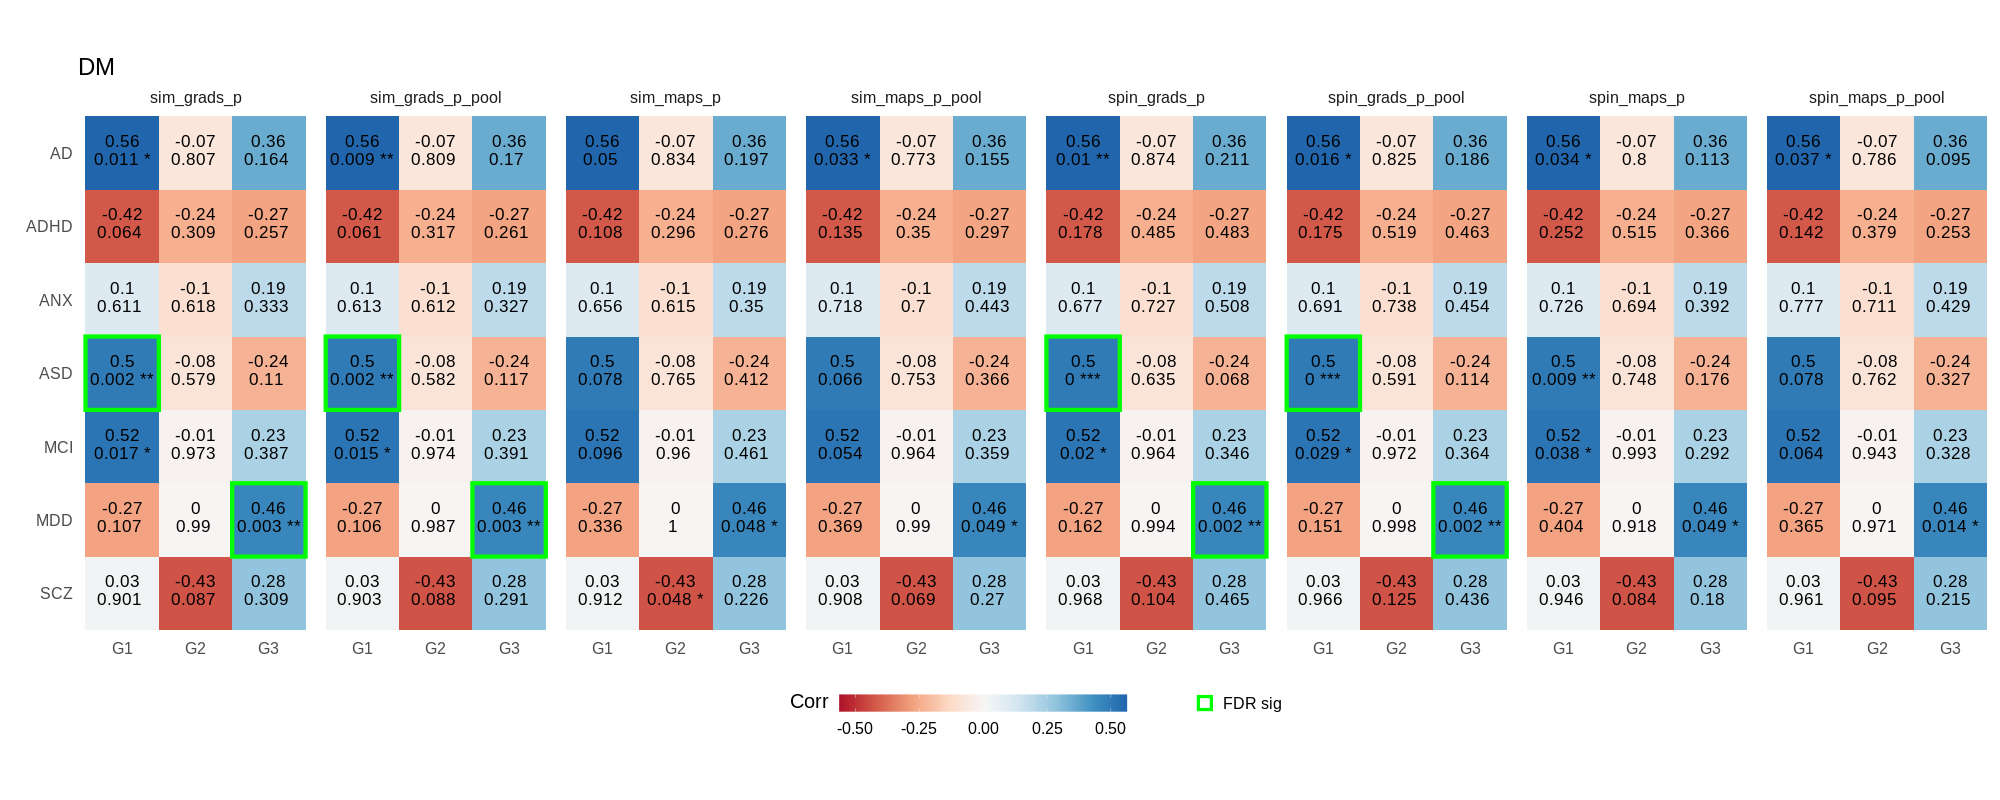

In [19]:
%%R -i corr_versions -w 2000 -h 800
source("../code/plot_maps.R")
plot_corr_versions(corr_versions) + ggtitle('DM')

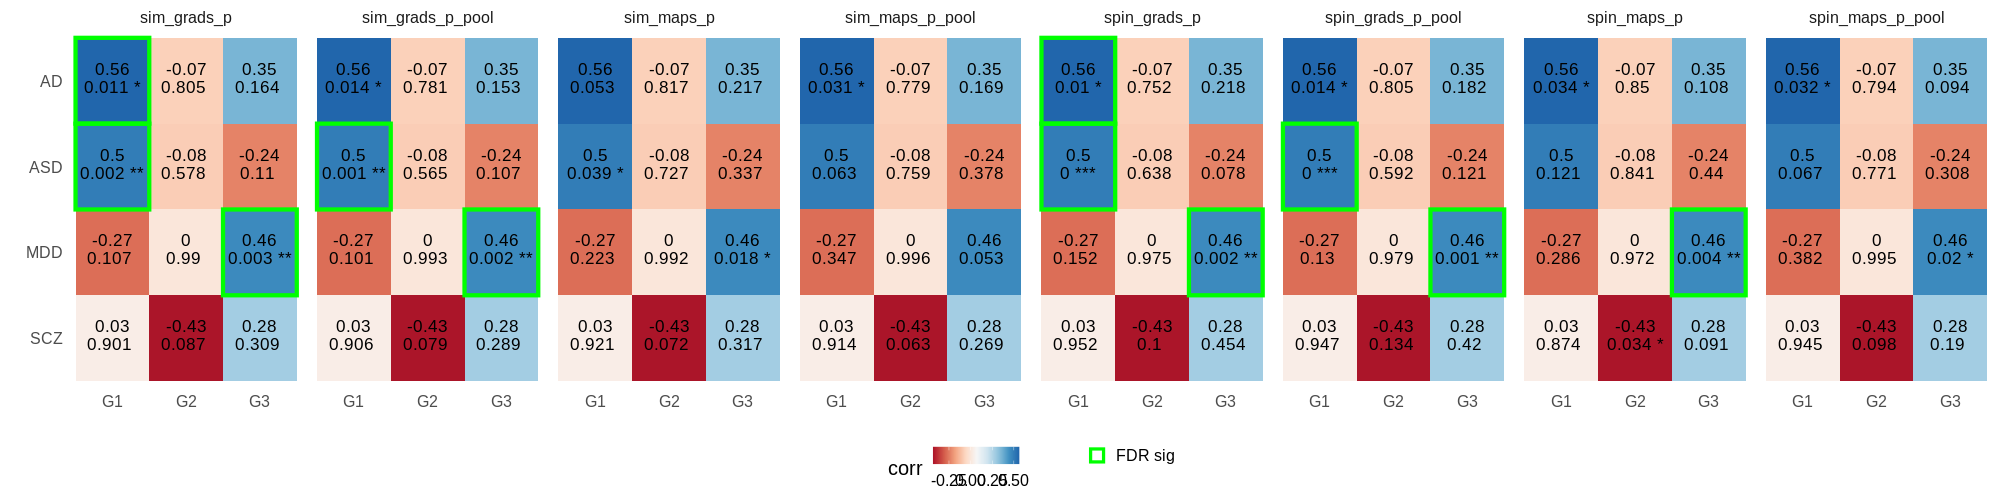

In [15]:
%%R -i corr_versions -w 2000 -h 500
source("../code/plot_maps.R")
plot_corr_versions(corr_versions)

In [23]:
corrs = get_corrs(scores, maps, atlas='dk')
null_corrs = null_corrs_dict['sim_grads_p']
null_p = get_null_p(corrs, null_corrs, adjust=None)
null_p

,map,G,pct,true_mean,null_mean,null_std,z,pos,p,sig
0,AD,G1,0.9947,0.561929,-0.005989,0.259345,2.189810,True,0.0106,True
1,AD,G2,0.4034,-0.074033,-0.000899,0.249010,-0.293700,False,0.8068,False
2,AD,G3,0.9182,0.355224,-0.002631,0.249773,1.432724,True,0.1636,False
3,ADHD,G1,0.0319,-0.423869,0.005280,0.236286,-1.816229,False,0.0638,False
4,ADHD,G2,0.1547,-0.243877,0.005450,0.232557,-1.072114,False,0.3094,False
5,ADHD,G3,0.1286,-0.271090,0.000194,0.231876,-1.169952,False,0.2572,False
6,ANX,G1,0.6947,0.102087,-0.000011,0.184454,0.553518,True,0.6106,False
7,ANX,G2,0.3089,-0.101832,-0.002299,0.183903,-0.541223,False,0.6178,False
8,ANX,G3,0.8337,0.190600,0.003804,0.183319,1.018964,True,0.3326,False
9,ASD,G1,0.9989,0.499031,-0.001185,0.150833,3.316351,True,0.0022,True


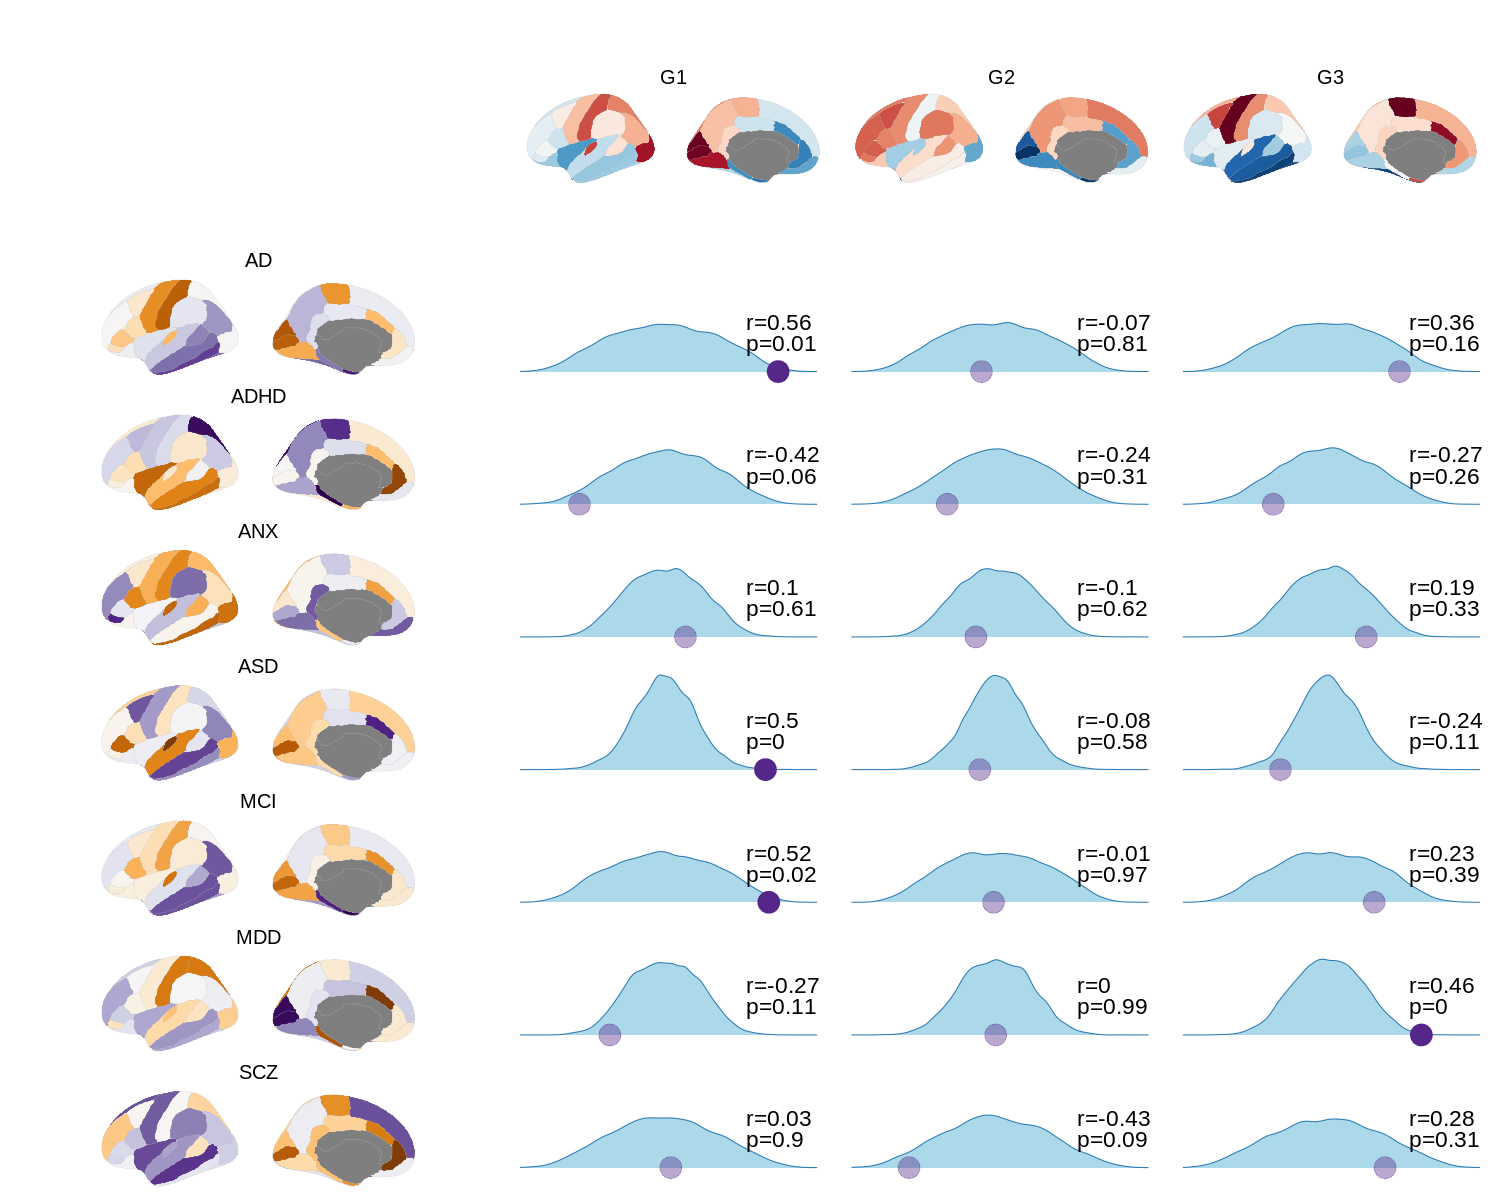

In [28]:
%%R -i corrs -i null_corrs -i null_p -i scores -i maps -w 2000 -h 1200
source("../code/plot_maps.R")
source("../code/brainPlots.R")
g1 <- plot_null_corrs(corrs, null_corrs, null_p)
g2 <- plot_dk_wide(scores, spacing=0) + guides(fill='none')
g3 <- plot_maps_dk(maps, colors=rev(brewer.puor(100)), ncol=1) + guides(fill='none')

(
((
    ((plot_spacer() | g2) + plot_layout(widths=c(1,2))) / 
    ((g3 | g1) + plot_layout(widths=c(1,2)))
) + plot_layout(heights=c(1,7)) 
) & theme(
    text=element_text(size=36),
)
) #+ plot_annotation(title='Sim grads', theme=theme(title=element_text(size=42)))